# Misc

In [42]:
train_path = 'data/training.csv'
test_path = 'data/test.csv'
look_up_path = 'data/IdLookupTable.csv'

In [12]:
import pandas as pd
from PIL import Image, ImageDraw
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import csv
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from itertools import product


# Data Cleanup / Initialization 

Out of the 7,049 rows, 4,755 of these rows are missing 22 fields. We are going to average out those missing fields

In [44]:
# This ONLY includes rows that have data for at least 1 keypoint
# Rows that only contain image data are not included
train_data = pd.read_csv(train_path)

missing_image_rows = train_data['Image'].isnull().sum()
print(f"Rows missing 'Image' field: {missing_image_rows}\n")

missing_counts = train_data.isnull().sum(axis=1).value_counts().sort_index()
for missing_fields, row_count in missing_counts.items():
    if missing_fields > 0:
        print(f"Rows missing {missing_fields} field(s): {row_count}")

Rows missing 'Image' field: 0

Rows missing 2 field(s): 87
Rows missing 4 field(s): 28
Rows missing 6 field(s): 9
Rows missing 8 field(s): 8
Rows missing 10 field(s): 3
Rows missing 12 field(s): 5
Rows missing 14 field(s): 2
Rows missing 20 field(s): 2
Rows missing 22 field(s): 4755
Rows missing 24 field(s): 10


Since a significant amonut of rows contain blank values, we will fill in these values with the average for the column. 

In the future it would be worth experimenting with removing these rows instead of filling them out. For now we are going to go with the idea that lots of flawed synthetic data is better than a small amount of quality data. 

In [45]:
column_means = {}

# Iterate over each column index except the last one
for i in range(train_data.shape[1] - 1):
    column_name = train_data.columns[i]
    mean_value = train_data.iloc[:, i].mean()
    column_means[column_name] = mean_value
print(column_means)

# Fill missing values using the precomputed means, except for the "Image" column
for column_name, mean_value in column_means.items():
    train_data[column_name].fillna(mean_value, inplace=True)
    
# save train_data
# train_data.to_csv('data/avg_train_data.csv', index=False)

# Make sure no blank vals go through
missing_row = train_data[train_data.isnull().any(axis=1)]
print(missing_row)

{'left_eye_center_x': 66.35902124475365, 'left_eye_center_y': 37.65123419193395, 'right_eye_center_x': 30.306101514079753, 'right_eye_center_y': 37.97694257172698, 'left_eye_inner_corner_x': 59.15933943740387, 'left_eye_inner_corner_y': 37.94475232796772, 'left_eye_outer_corner_x': 73.3304779831461, 'left_eye_outer_corner_y': 37.707008310792986, 'right_eye_inner_corner_x': 36.65260694805725, 'right_eye_inner_corner_y': 37.98990191451049, 'right_eye_outer_corner_x': 22.384504479169355, 'right_eye_outer_corner_y': 38.03349517525053, 'left_eyebrow_inner_end_x': 56.06851307930929, 'left_eyebrow_inner_end_y': 29.332678249311716, 'left_eyebrow_outer_end_x': 79.48282586419953, 'left_eyebrow_outer_end_y': 29.734860732432317, 'right_eyebrow_inner_end_x': 39.32213692201747, 'right_eyebrow_inner_end_y': 29.502998474112996, 'right_eyebrow_outer_end_x': 15.871177472719152, 'right_eyebrow_outer_end_y': 30.428165911873432, 'nose_tip_x': 48.37418629032876, 'nose_tip_y': 62.71588359736171, 'mouth_left_

/var/folders/kp/vdv61pd97vd0x29b257r8h7h0000gn/T/ipykernel_32873/2586996622.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[column_name].fillna(mean_value, inplace=True)


In [46]:
features = train_data.iloc[:, :-1].apply(pd.to_numeric, errors='coerce').values
images = train_data.iloc[:, -1].str.split().apply(lambda x: np.array(x, dtype='float32').reshape(96, 96)).values

features_tensor = torch.tensor(features, dtype=torch.float32)
images_tensor = torch.stack([torch.tensor(img) for img in images])


In [17]:
class FacialKeypointsDataset(Dataset):
    def __init__(self, images, keypoints):
        self.images = images
        self.keypoints = keypoints

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].unsqueeze(0)  # Add a channel dimension
        keypoints = self.keypoints[idx]
        return image, keypoints
    
dataset = FacialKeypointsDataset(images_tensor, features_tensor)


In [47]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

combined_training_data = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

# Data Analysis
There seems to be some outliars in the training data. Not enough to make a big deal over though. 

TODO: Need more investigation to these outliars to see if they are legitimate or not.

When the model sees the data that is obviously synthetic it might be able to recognize that this data is less significant when making predicitons? 

TODO: Might be worth investigating if synthetic data made with a normal distribution would be better than just a simple mean.

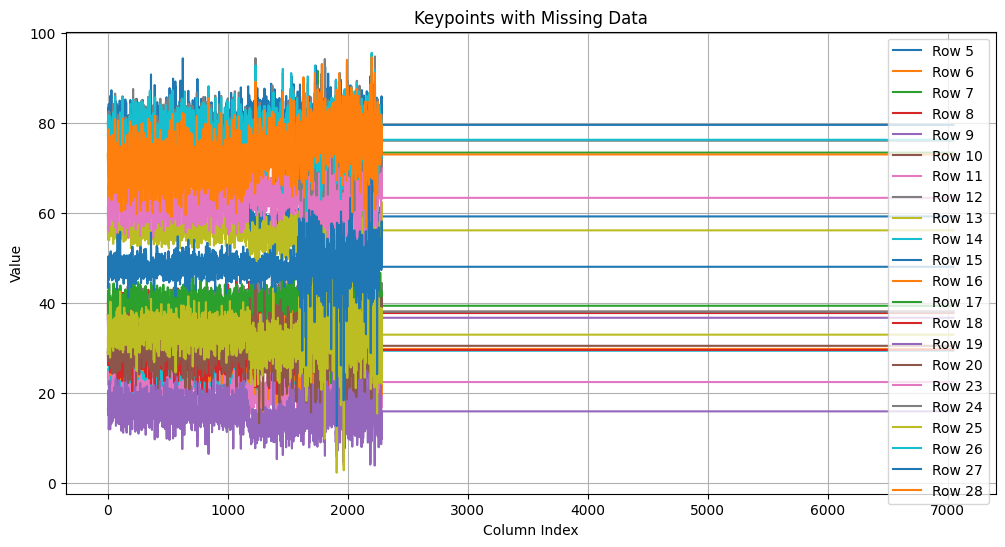

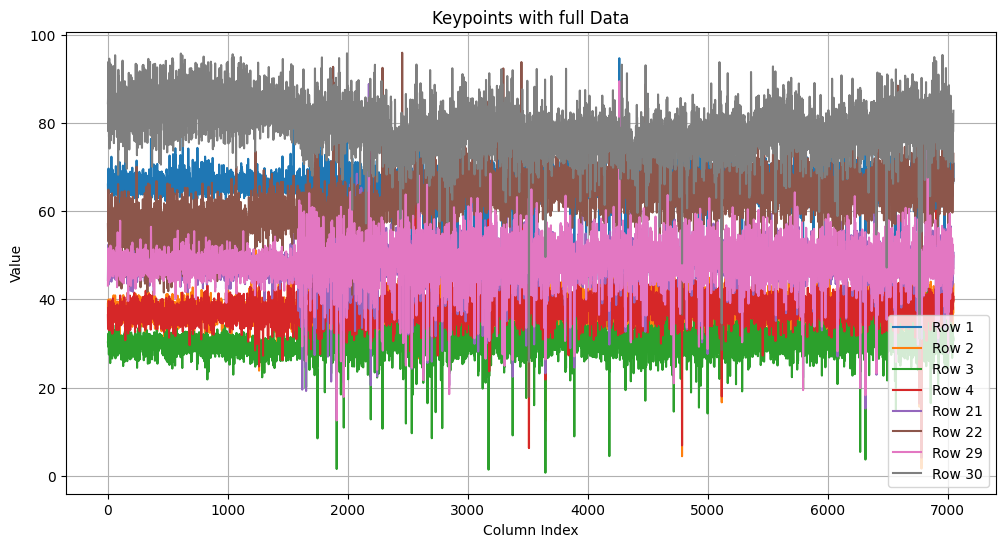

In [11]:
# Graph of keypoints that do not have enough data
plt.figure(figsize=(12, 6))

for i in range(4, 20):
    plt.plot(train_data.iloc[:, i], label=f'Row {i+1}')
    
plt.plot(train_data.iloc[:, 22], label=f'Row {23}')
plt.plot(train_data.iloc[:, 23], label=f'Row {24}')
plt.plot(train_data.iloc[:, 24], label=f'Row {25}')
plt.plot(train_data.iloc[:, 25], label=f'Row {26}')
plt.plot(train_data.iloc[:, 26], label=f'Row {27}')
plt.plot(train_data.iloc[:, 27], label=f'Row {28}')

plt.title('Keypoints with Missing Data')
plt.xlabel('Column Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


# Graph 2
plt.figure(figsize=(12, 6))
plt.plot(train_data.iloc[:, 0], label=f'Row {1}')
plt.plot(train_data.iloc[:, 1], label=f'Row {2}')
plt.plot(train_data.iloc[:, 2], label=f'Row {3}')
plt.plot(train_data.iloc[:, 3], label=f'Row {4}')
plt.plot(train_data.iloc[:, 20], label=f'Row {21}')
plt.plot(train_data.iloc[:, 21], label=f'Row {22}')

plt.plot(train_data.iloc[:, 28], label=f'Row {29}')
plt.plot(train_data.iloc[:, 29], label=f'Row {30}')
    
plt.title('Keypoints with full Data')
plt.xlabel('Column Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Training

## Init Model

Training a Resnet model

In [54]:
class KeypointCNN(nn.Module):
    def __init__(self):
        super(KeypointCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 3 * 3, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 30)  # 15 keypoints * 2 (x, y) coordinates
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Mean Squared Error Loss Function
criterion = nn.MSELoss()
lr = 1e-3
batch_size = 64

# Training records

## CNN
- branch name: normal_cnn
- Base model
    - 8.0 loss
- Tested every iteration of 0.001, 0.0001, batchsize=64, batchsize=32
    - 0.0001 Learning Rate with batch size of 32 best
    - 7.5 validation loss

## Resnet
- Add residual connections between max pooling
- Performance started to flatten off after 30 epochs
- Validation Loss: ~7.15

## Resnet with dropouts
- Add two droupout layers to fully connected layers
- 50% change for dropout
- Validation loss
    - ~7.2
- Very dissapointing results

## CNN with Batch Normalization and Dropouts
- Add Batch2d normalization after each layer 
- WAYYY faster training (about 3.5x faster than resnet)
- Validation loss
    - ~7.2
- Training loss
    - 17
- batch size: 32
- learning rate 0.0001
- batch: 64 and LR: 1e3
    - validation loss: 7.1

In [59]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

model = KeypointCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, keypoints in combined_training_data:
        images = images.to(device)
        keypoints = keypoints.view(keypoints.size(0), -1).to(device)
        
        outputs = model(images)
        loss = criterion(outputs, keypoints)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # model.eval()
    # val_loss = 0.0
    # with torch.no_grad():
    #     for images, keypoints in val_dataloader:
    #         images = images.to(device)
    #         keypoints = keypoints.view(keypoints.size(0), -1).to(device)
            
    #         outputs = model(images)
    #         loss = criterion(outputs, keypoints)
            
    #         val_loss += loss.item()
    
    # val_loss /= len(val_dataloader)
    scheduler.step()

    print(f'Epoch: {epoch+1}, Training Loss: {running_loss/len(train_dataloader):.4f}, Validation Loss: {val_loss:.4f}')

# save the weights
torch.save(model.state_dict(), 'cnn_normalized_b63e3.pth')


Epoch: 1, Training Loss: 163.3928, Validation Loss: 8.6814
Epoch: 2, Training Loss: 39.9034, Validation Loss: 8.4412
Epoch: 3, Training Loss: 33.9876, Validation Loss: 19.0401
Epoch: 4, Training Loss: 30.4077, Validation Loss: 16.4759
Epoch: 5, Training Loss: 29.2409, Validation Loss: 12.9125
Epoch: 6, Training Loss: 27.3843, Validation Loss: 11.0571
Epoch: 7, Training Loss: 26.3171, Validation Loss: 8.3302
Epoch: 8, Training Loss: 25.5959, Validation Loss: 19.7973
Epoch: 9, Training Loss: 27.2552, Validation Loss: 7.4875
Epoch: 10, Training Loss: 24.9696, Validation Loss: 15.2609
Epoch: 11, Training Loss: 27.4051, Validation Loss: 31.7640
Epoch: 12, Training Loss: 25.9137, Validation Loss: 13.4844
Epoch: 13, Training Loss: 23.0924, Validation Loss: 7.7799
Epoch: 14, Training Loss: 24.3093, Validation Loss: 11.9103
Epoch: 15, Training Loss: 24.4920, Validation Loss: 7.5413
Epoch: 16, Training Loss: 23.0854, Validation Loss: 16.3347
Epoch: 17, Training Loss: 24.4284, Validation Loss: 7.

# Predictions

In [28]:
predictions = []
test_df = pd.read_csv(test_path)
id_lookup_table_df = pd.read_csv('./data/IdLookupTable.csv')

def preprocess_image(image_data):
    image = np.array(image_data.split(), dtype='float32').reshape(96, 96)
    return image

# Apply the preprocessing to the test images
test_images = test_df['Image'].apply(preprocess_image).values

# Convert the preprocessed images to a tensor
test_images_tensor = torch.stack([torch.tensor(img) for img in test_images])

# Move the tensor to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_images_tensor = test_images_tensor.unsqueeze(1).to(device)

feature_to_index = {
    'left_eye_center_x': 0, 'left_eye_center_y': 1,
    'right_eye_center_x': 2, 'right_eye_center_y': 3,
    'left_eye_inner_corner_x': 4, 'left_eye_inner_corner_y': 5,
    'left_eye_outer_corner_x': 6, 'left_eye_outer_corner_y': 7,
    'right_eye_inner_corner_x': 8, 'right_eye_inner_corner_y': 9,
    'right_eye_outer_corner_x': 10, 'right_eye_outer_corner_y': 11,
    'left_eyebrow_inner_end_x': 12, 'left_eyebrow_inner_end_y': 13,
    'left_eyebrow_outer_end_x': 14, 'left_eyebrow_outer_end_y': 15,
    'right_eyebrow_inner_end_x': 16, 'right_eyebrow_inner_end_y': 17,
    'right_eyebrow_outer_end_x': 18, 'right_eyebrow_outer_end_y': 19,
    'nose_tip_x': 20, 'nose_tip_y': 21,
    'mouth_left_corner_x': 22, 'mouth_left_corner_y': 23,
    'mouth_right_corner_x': 24, 'mouth_right_corner_y': 25,
    'mouth_center_top_lip_x': 26, 'mouth_center_top_lip_y': 27,
    'mouth_center_bottom_lip_x': 28, 'mouth_center_bottom_lip_y': 29
}

model = KeypointCNN().to(device)
model.load_state_dict(torch.load('combined_keypoint_resnet.pth'))
model.eval()

KeypointCNN(
  (conv_layers): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplac

In [29]:
with torch.no_grad():
    for i in range(len(test_images_tensor)):
        image = test_images_tensor[i].unsqueeze(0)  # Add batch dimension
        outputs = model(image)
        outputs = outputs.cpu().numpy().reshape(-1, 2)  # Reshape to (15, 2) format
        
        # Retrieve the corresponding entries in the IDLookupTable
        image_id = test_df.iloc[i]['ImageId']
        lookup_entries = id_lookup_table_df[id_lookup_table_df['ImageId'] == image_id]
        
        for _, entry in lookup_entries.iterrows():
            feature_name = entry['FeatureName']
            row_id = entry['RowId']
            
            # Use the mapping to get the correct feature index
            feature_index = feature_to_index[feature_name]
            
            # Find the corresponding prediction
            predicted_location = outputs[feature_index // 2, feature_index % 2]
            predictions.append((row_id, predicted_location))

# Create a dataframe for the submission
submission_df = pd.DataFrame(predictions, columns=['RowId', 'Location'])

In [36]:
def print_image(image_ID):
    # Extract raw image data
    image_raw = test_images[image_ID]

    # Prepare the formatted image
    formatted_image = image_raw.reshape(96, 96)

    # Create an image from the array
    img = Image.fromarray(np.array(formatted_image, dtype=np.uint8), mode='L').convert('RGB')
    draw = ImageDraw.Draw(img)

    # Retrieve the corresponding predictions for the given image_ID
    image_id = test_df.iloc[image_ID]['ImageId']
    lookup_entries = submission_df[submission_df['RowId'].isin(
        id_lookup_table_df[id_lookup_table_df['ImageId'] == image_id]['RowId'].values
    )]

    # Extract the predicted keypoints from the submission dataframe
    predicted_points = []
    for _, row in lookup_entries.iterrows():
        row_id = row['RowId']
        feature_name = id_lookup_table_df[id_lookup_table_df['RowId'] == row_id]['FeatureName'].values[0]
        predicted_location = row['Location']

        # Append the predicted location
        predicted_points.append((feature_name, predicted_location))

    # Sort the predicted points to match the expected order for drawing
    predicted_points.sort(key=lambda x: feature_to_index[x[0]])

    # Draw the keypoints on the image
    points = np.array([pt[1] for pt in predicted_points]).reshape(-1, 2)
    for point in points:
        draw.ellipse((point[0] - 1, point[1] - 1, point[0] + 1, point[1] + 1), fill='red', outline='red')

    # Show the image
    img.show()
print_image(5)

In [38]:
submission_df.to_csv('data/submission.csv', index=False)

In [39]:
print(submission_df.shape)

(27124, 2)


# Submissions


## Submission 1
- Public data score
    - Constantly rolling leaderboard
    - 3.527
    - 93rd out of 164
- Private data score
    - Old competition leaderboard
    - 3.763
    - 83rd out of 175 place

